In [1]:
#!pip install selenium
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import nltk
import csv
import time
import numpy as np
import cvxpy as cvx
from selenium import webdriver
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/phili1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/phili1/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/phili1/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
import time
from selenium import webdriver
from selenium.common.exceptions import StaleElementReferenceException, NoSuchElementException, NoSuchWindowException

# URL to the first page of audience reviews for Casino Royale
URL = 'https://www.rottentomatoes.com/m/casino_royale/reviews?type=user'
# create a Chrome webdriver 
driver = webdriver.Chrome('/Users/phili1/Downloads/chromedriver')  # Optional argument, if not specified will search path.
# driver.implicitly_wait(1)
first_review_prev_batch = ''
num_reviews = 0            
def store_data():
    global num_reviews 
    global first_review_prev_batch
    reviews = []
    rates = []
    while True:
        try:
            all_reviews = driver.find_elements_by_class_name('audience-reviews__item')
            end = len(all_reviews)
            i = 0
            for element in all_reviews:
                i += 1
                p_elem = element.find_element_by_xpath(".//p[@class='audience-reviews__review js-review-text clamp clamp-8 js-clamp']")
                review = p_elem.text
                if review == first_review_prev_batch:
                    break
                reviews.append(review)
                # get the number of stars (full or half)
                star_elem = element.find_elements_by_css_selector(".star-display__filled")
                # if there are more than 3 full stars (rate >= 3.5), then the review is positive
                if len(star_elem) > 3:
                    rate = 'positive'
                else:
                    rate = 'negative'
                rates.append(rate)
            if i == end:
                break
        # StaleElementsReferenceException occurs when my internet connection was slow, and 
        # therefore the web navigates after the data is scraped, causing insconsitencies.
        # Therefore, this exception needs to be caught.
        except StaleElementReferenceException:
            reviews = []
            rates = []
            pass
    
    # write to csv file:
    for i in range(len(reviews)):
        if i==0:
            first_review_prev_batch = reviews[i]
        with open('rottentomato.csv', mode='a') as file:
            writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow([reviews[i], rates[i]])
    num_reviews += len(reviews)
            

with open('rottentomato.csv', mode='w') as file:
            writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['text', 'label'])
driver.get(URL);
store_data()

while True:
    if num_reviews >= 20000:
        break
    try:
        driver.find_element_by_class_name('js-prev-next-paging-next').click()
        time.sleep(1)
    except:
        break
    store_data()
driver.quit()

/var/folders/q7/vcl44_tj7gs2cg2r8fc3tqgr0000gq/T/ipykernel_36573/3058070728.py:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/phili1/Downloads/chromedriver')  # Optional argument, if not specified will search path.
/var/folders/q7/vcl44_tj7gs2cg2r8fc3tqgr0000gq/T/ipykernel_36573/3058070728.py:19: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  all_reviews = driver.find_elements_by_class_name('audience-reviews__item')
/Users/phili1/opt/anaconda3/lib/python3.9/site-packages/selenium/webdriver/remote/webelement.py:393: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")
/Users/phili1/opt/anaconda3/lib/python3.9/site-packages/selenium/webdriver/remote/webelement.py:502: UserWarning: find_elements_by_* commands are deprecated. 

# Prep data

In [6]:
np.random.seed(500)
Corpus = pd.read_csv(r"rottentomato.csv",encoding='latin-1')
Corpus.head()

,text,label
0,Casino Royale aka The Adventures of the Sneaky...,positive
1,"Casino Royale is filled with action, drama and...",positive
2,"James Bond is acted decently, the film however...",negative
3,"Daniel Craig begins his outings as Bond, James...",positive
4,And now to Daniel Craig. I remember all the fl...,positive


In [7]:
nltk.download('stopwords')
# Step - a : Remove blank rows if any.
Corpus['text'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['text'] = [entry.lower() for entry in Corpus['text']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['text']= [word_tokenize(entry) for entry in Corpus['text']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Corpus['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

Corpus.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/phili1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,text_final
0,"[casino, royale, aka, the, adventures, of, the...",positive,"['casino', 'royale', 'aka', 'adventure', 'snea..."
1,"[casino, royale, is, filled, with, action, ,, ...",positive,"['casino', 'royale', 'fill', 'action', 'drama'..."
2,"[james, bond, is, acted, decently, ,, the, fil...",negative,"['james', 'bond', 'act', 'decently', 'film', '..."
3,"[daniel, craig, begins, his, outings, as, bond...",positive,"['daniel', 'craig', 'begin', 'outing', 'bond',..."
4,"[and, now, to, daniel, craig, ., i, remember, ...",positive,"['daniel', 'craig', 'remember', 'flack', 'anno..."


In [8]:
# train test split
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['label'],test_size=0.3)
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
print('Shape of training data:', Train_X_Tfidf.shape)
print('Shape of training label:', Train_Y.shape)
print('Shape of testing data:', Test_X_Tfidf.shape)
print('Shape of testing label:', Test_Y.shape)


Shape of training data: (14000, 5000)
Shape of training label: (14000,)
Shape of testing data: (6000, 5000)
Shape of testing label: (6000,)


In [9]:
# the size of the vocab 
print(len(Tfidf_vect.vocabulary_))
# Relabel the data so that the labels are 1 and -1
for i in range(Train_Y.shape[0]):
    if Train_Y[i] == 0:
        Train_Y[i] = -1

5000


# CVXPY

In [13]:
def svm_cvx(x,y,C=1):
    # define some parameters
    # number of samples/ data poitns
    n = x.shape[0]
    # number of features
    m = x.shape[1]


    # create variables
    w = cvx.Variable(m)
    eps = cvx.Variable(n) # a vector of n epsilons corresponding to n data points
    b = cvx.Variable()

    # objective function
    obj = cvx.Minimize((cvx.norm(w))**2)
    obj = cvx.Minimize(cvx.sum_squares(w))
    # prob = cvx.Problem(obj)
    # cvx.sum_squares(w) is w.T w 
    obj = cvx.Minimize(.5*cvx.sum_squares(w) + C*cvx.sum(eps))
    # constraints
    ## Constraint set 1. y_i(w.Tx_i + b)>= 1 - eps_i
    con = [-y[i]*(x[i]@w + b) + 1 - eps[i] <= 0 for i in range(n)]
    # con = [-y[i]*(cvx.sum(cvx.multiply(w,x[i])) + b) + 1 - eps[i] <= 0 for i in range(n)]
    ## Constraint set 2.
    # con = [w[i] <= 0 for i in range(m)]
    con.extend([-eps[i] <= 0 for i in range(n)])

    # solve the problem 
    prob = cvx.Problem(obj, con)
    prob.solve() 
    return w.value, b.value, prob.value 

def compute_decision(w,b,x):
    """
    Given w and b, calculate the classification of all data points x.
    
    Inputs:
    - w: array of shape (m,). m is the number of features
    - b: float 
    - x: array of shape (n,m), containing the data points to classify
    """
    m = w.shape[0]
    n = x.shape[0]
    decision = np.matmul(w.transpose().reshape((1,m)), x.transpose()) +b 
    # one side of the decision boundary is class 1, the other class -1 
    decision[decision>0] = 1
    decision[decision<=0] = -1
    return decision 

# CVXPY vs Sklearn
**This part shows that cvxpy implementation works properly**

In [14]:
C_list = [0.1, 0.5, 1, 2, 5, 8, 10]
diff_list = []
predictions = []
margin_width_list = []
cost_list = []
for C in C_list:
    # sklearn implementation
    SVM = svm.SVC(C=C, kernel='linear',)
    SVM.fit(Train_X_Tfidf,Train_Y)
    # predict the labels on validation dataset
    predict_sk = SVM.predict(Test_X_Tfidf)
    
    # CVXPY implementation
    w, b, cost = svm_cvx(x=Train_X_Tfidf.toarray(), y=Train_Y, C=C)
    # store the margin width
    margin_width_list.append(2/((w.dot(w))**.5))
    # store the cost
    cost_list.append(cost)
    # predict the labels on validation dataset
    predict_cvx = compute_decision(w,b,x=Test_X_Tfidf.toarray())
    predictions.append(predict_cvx)
    # compare the predictions from the 2 implementations
    num_diff = np.sum(predict_sk != predict_cvx)
    diff_list.append(num_diff)
    print('Finished C=', C)

print()
for i in range(len(C_list)):
    print('C =', C_list[i], ':', diff_list[i], 'mismatches')

Finished C= 0.1
Finished C= 0.5
Finished C= 1
Finished C= 2
Finished C= 5
Finished C= 8
Finished C= 10

C = 0.1 : 0 mismatches
C = 0.5 : 0 mismatches
C = 1 : 3 mismatches
C = 2 : 1 mismatches
C = 5 : 1 mismatches
C = 8 : 0 mismatches
C = 10 : 0 mismatches


# Evaluate

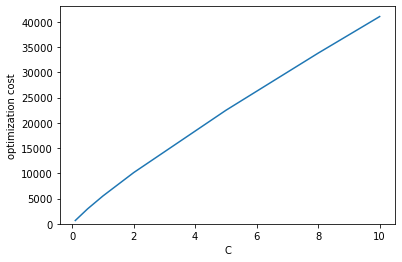

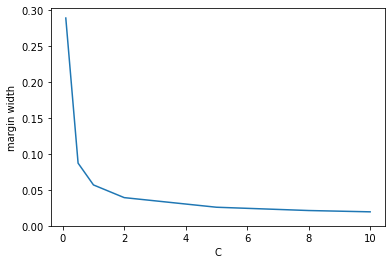

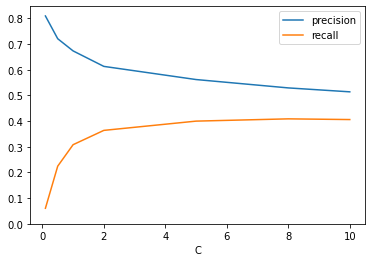

In [15]:
# Relabel the test data so that the labels are 1 and -1
for i in range(Test_Y.shape[0]):
    if Test_Y[i] == 0:
        Test_Y[i] = -1
        
# C vs cost 
import matplotlib.pyplot as plt
plt.plot(C_list, cost_list)
plt.ylim(ymin=0)
plt.xlabel('C')
plt.ylabel('optimization cost')
plt.show()

print()
# C vs marin width
plt.plot(C_list, margin_width_list)
plt.ylim(ymin=0)
plt.xlabel('C')
plt.ylabel('margin width')
plt.show()

print()
# precision vs recall 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
y_true = Test_Y
precision_list = []
recall_list = []
# precision and recall for different values of C
for i in range(len(C_list)):
    y_pred = predictions[i].reshape(6000)
    # compute precision
    precision_list.append(precision_score(y_true, y_pred, pos_label=-1))
    # compute recall
    recall_list.append(recall_score(y_true, y_pred, pos_label=-1))
    

# plot it!
import matplotlib.pyplot as plt
plt.plot(C_list, precision_list, label='precision')
plt.plot(C_list, recall_list, label='recall')
plt.ylim(ymin=0)
plt.legend()
plt.xlabel('C')
plt.show()
